# Data Engineering

In [272]:
import missingno as msno
import pandas as pd
from numpy import nan, sin, cos, pi
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

%matplotlib inline

In [273]:
data = pd.read_csv("../docs/dataset_DT.csv")
data.dtypes

age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day          float64
month         object
duration     float64
campaign     float64
pdays        float64
previous     float64
poutcome      object
y             object
dtype: object

In [274]:
for col in data.columns:
    if data[col].dtype == "object":
        data[col] = data[col].replace([nan, "", " ", "unknown"], pd.NA)

data["pdays"] = data["pdays"].replace([-1], [float(nan)])


<Axes: >

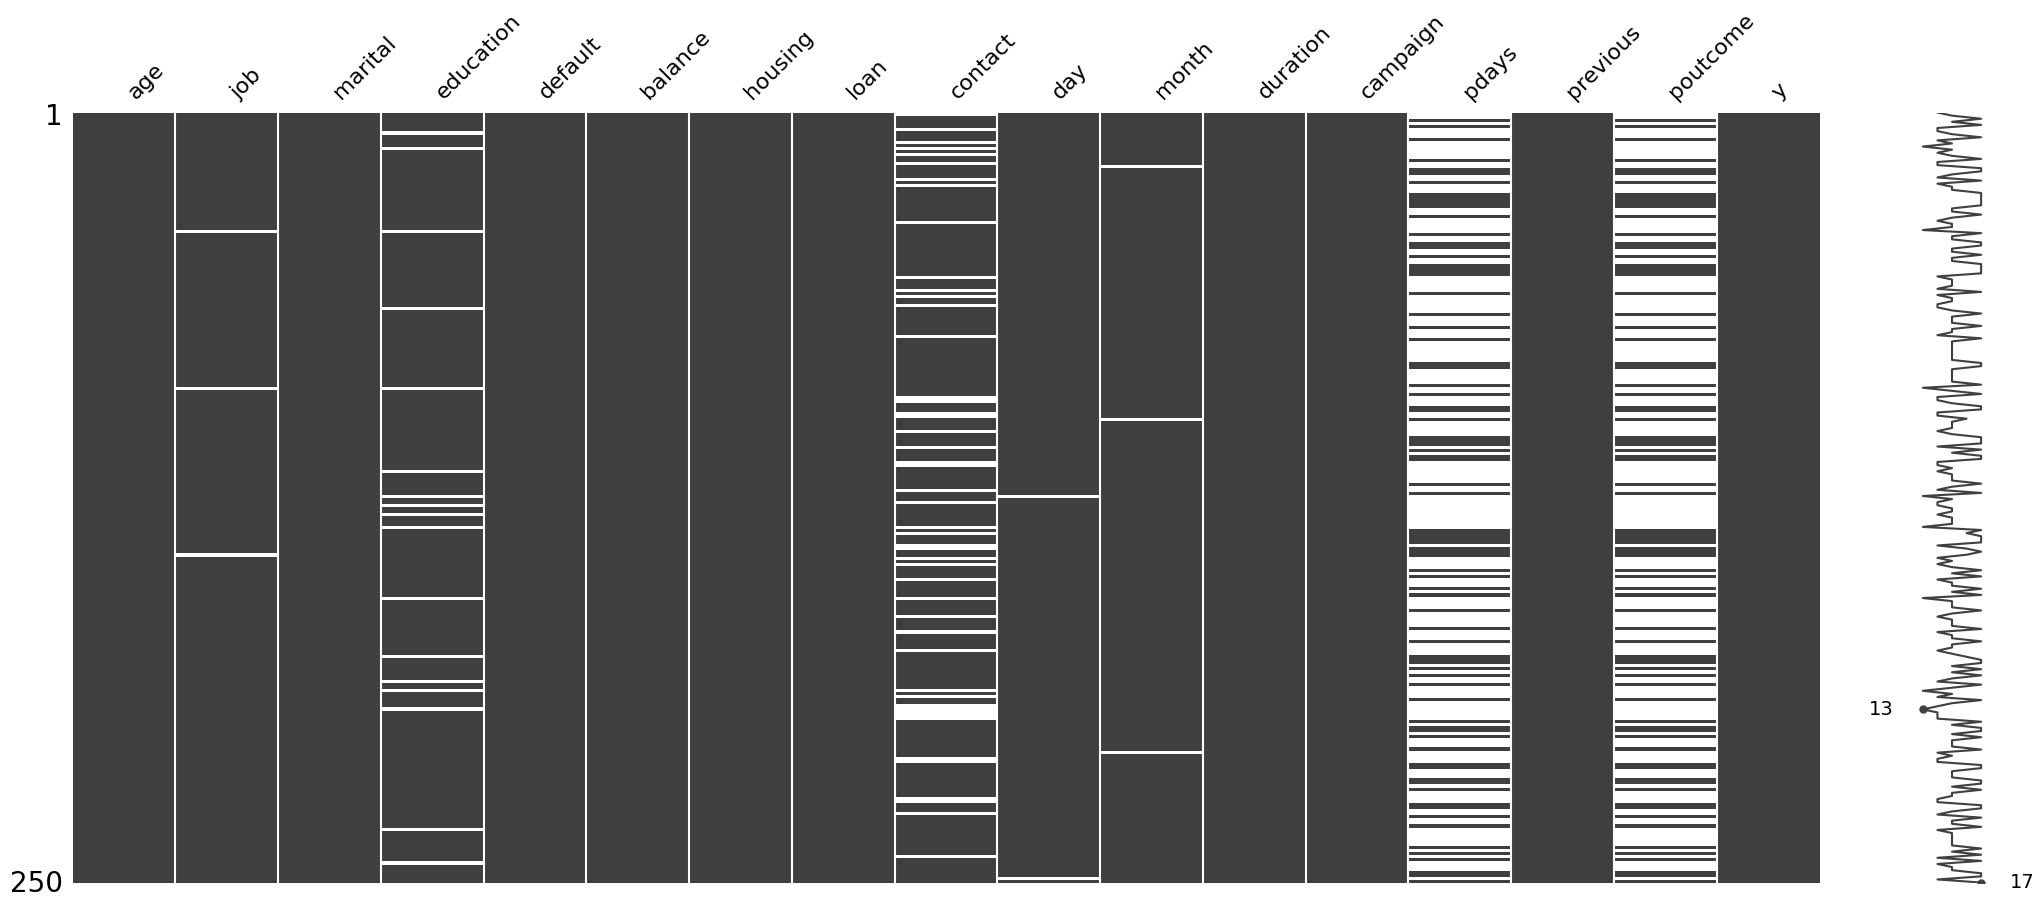

In [275]:
msno.matrix(data.sample(250))

The above density matrix shows that there is a relationship between the missing values in `pdays` and `poutcome`. The other features (excluding contact) have negligible missing values.

<Axes: >

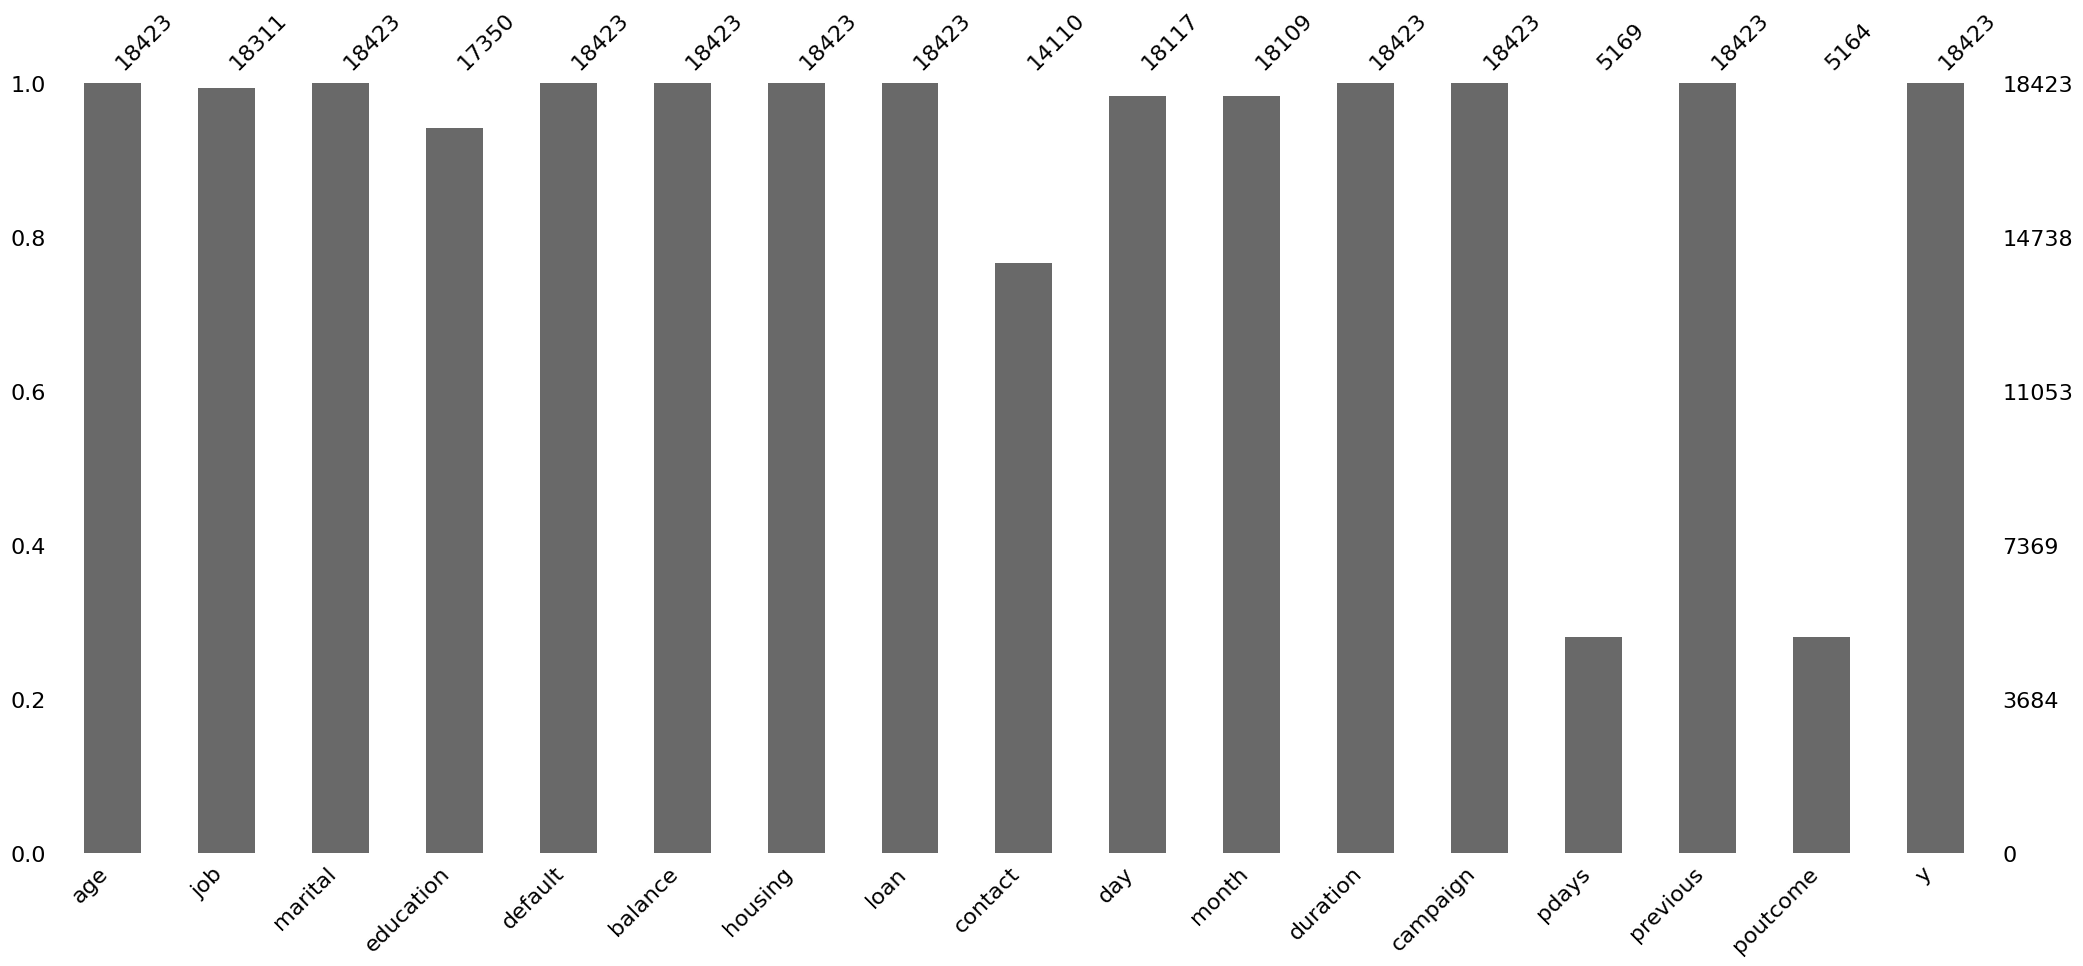

In [276]:
msno.bar(data)

The above figure shows the counts of missing values in each column/feature. We can clearly see `contact`, `pdays` and `poutcome` have a lot of missing values.

<Axes: >

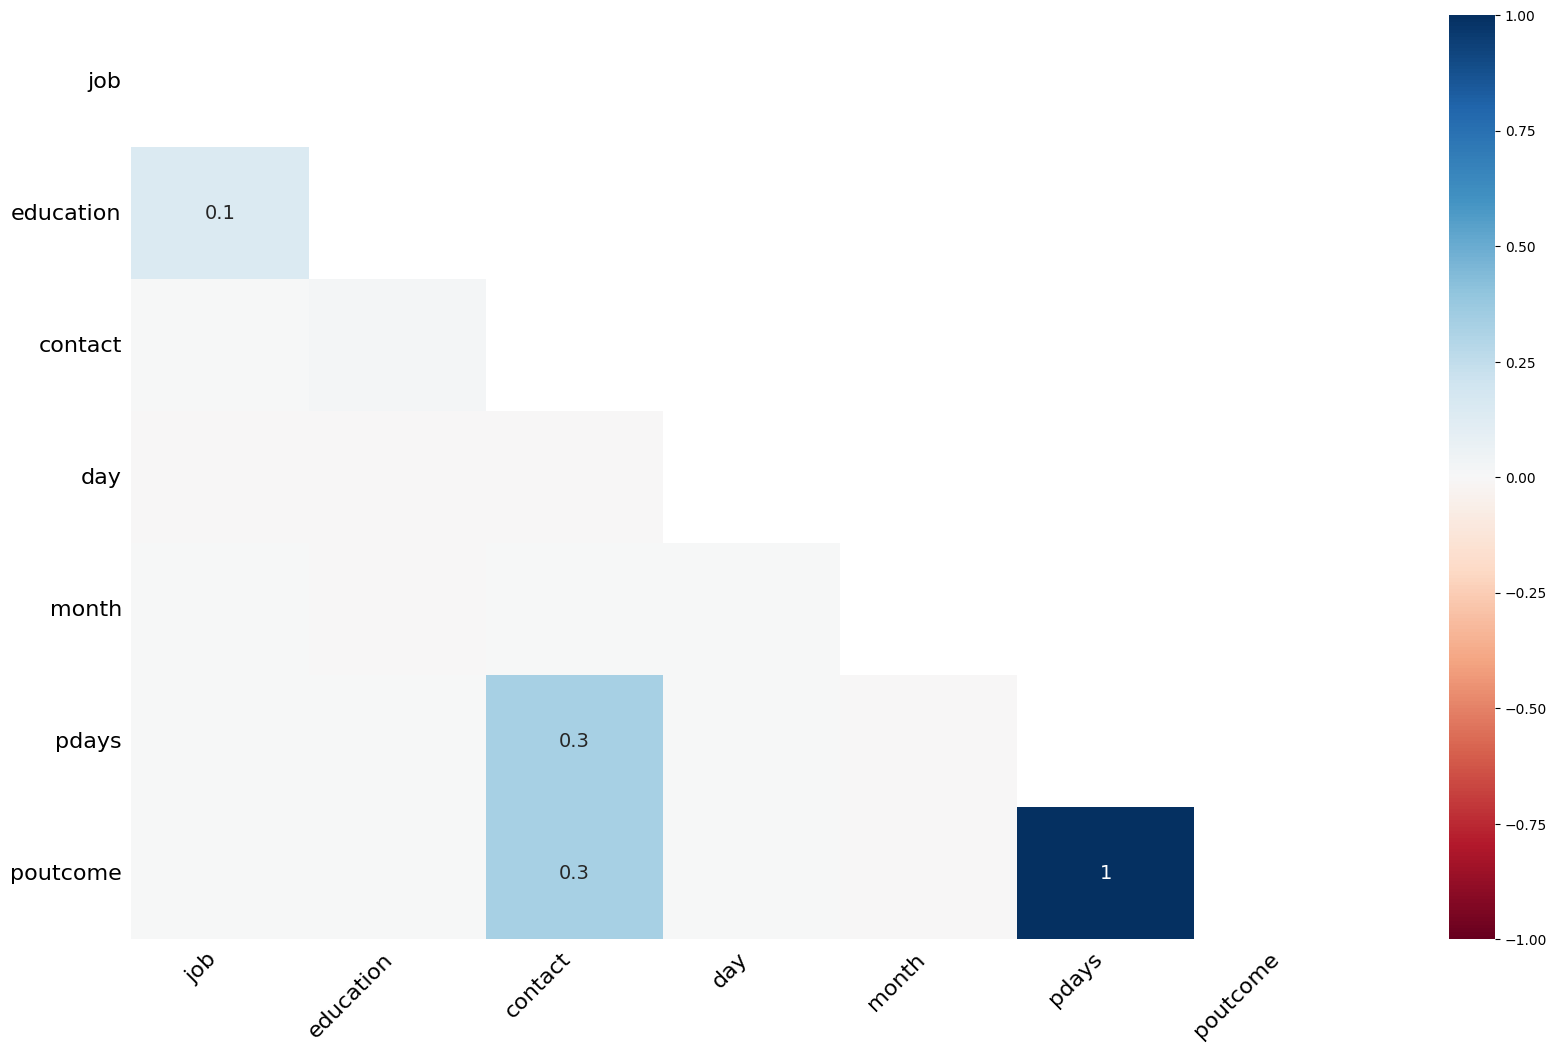

In [277]:
msno.heatmap(data)

The above heatmap show the relationship between the missing values in each column. We can clearly see that there is `100%` co-relation between the missing values of `poutcome` and `pdays`.

<Axes: >

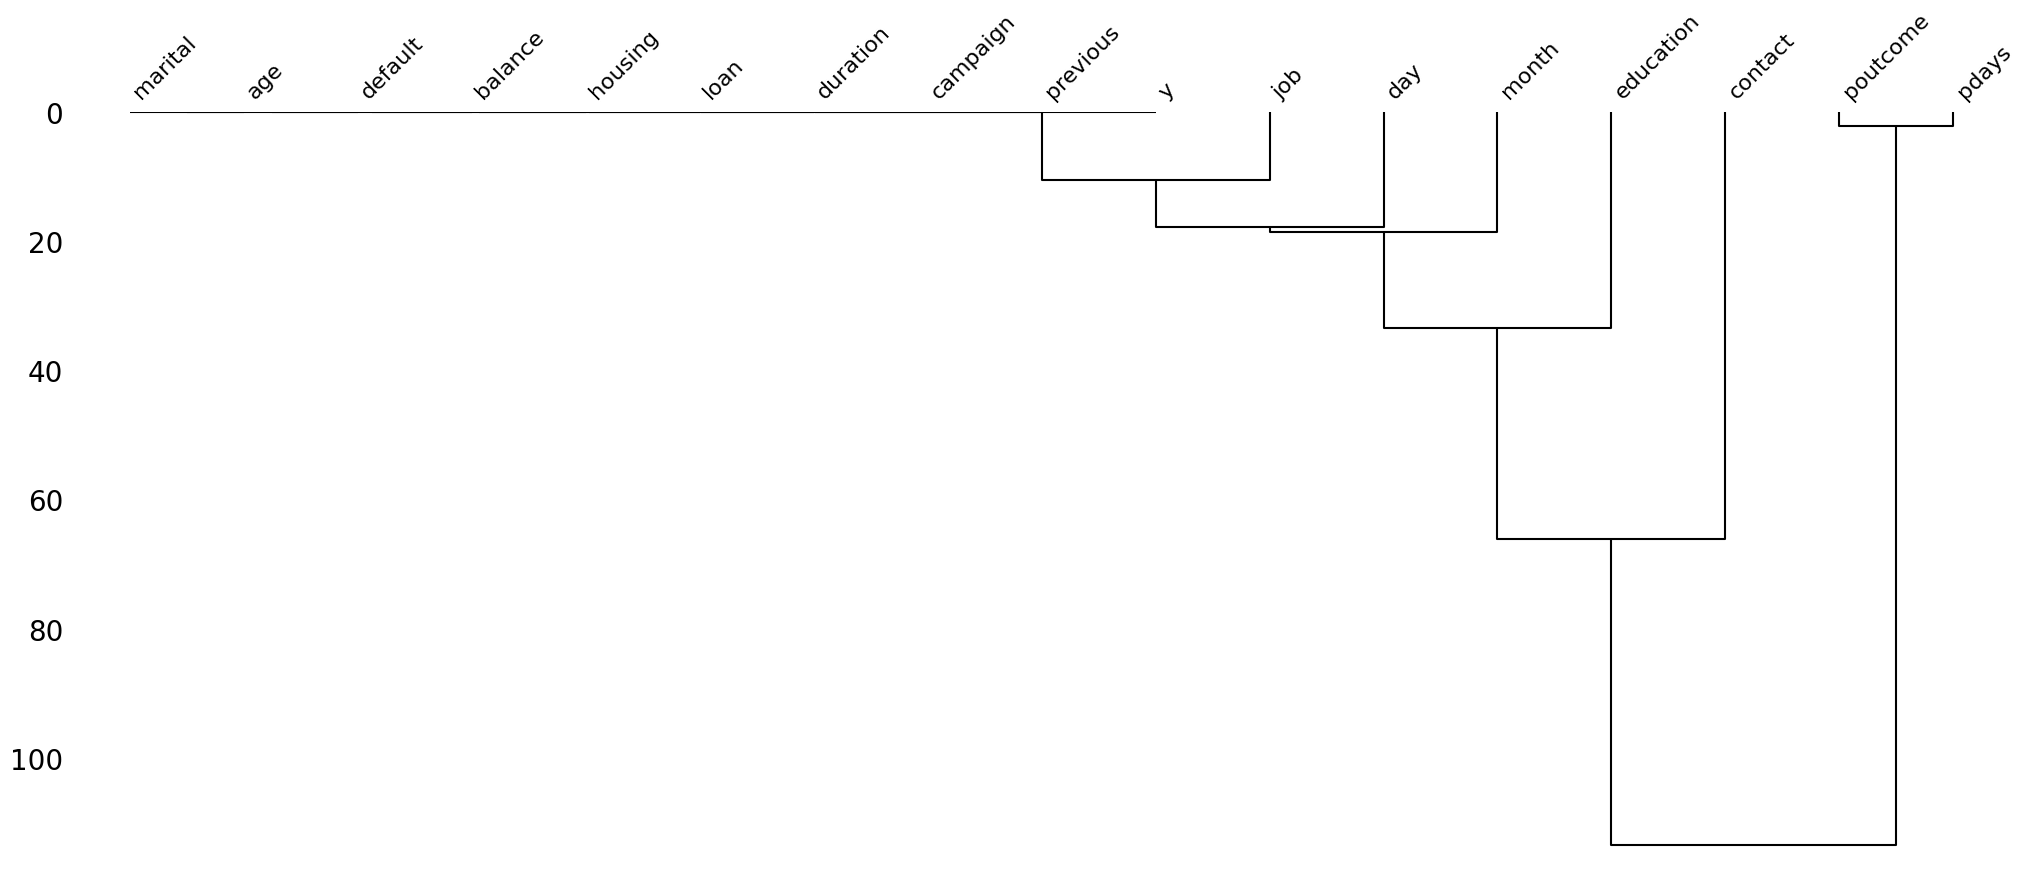

In [278]:
msno.dendrogram(data)

The above dendogram shows the hierarchical clustering of missing values. 
- `pdays` and `poutcome`: These two columns are clustered together, suggesting that when one of these columns has missing values, the other is likely to have missing values too. This makes sense, as you mentioned earlier that both columns relate to information from previous campaigns.
- `education`, `contact`, `month`, `job`: These columns form another cluster, indicating that missing values in these columns are related, i.e., they tend to miss together. 
- `marital`, `age`, `default` etc. appear to be less related to other variables in terms of missing data. They branch out earlier, meaning their missing values are less likely to occur alongside missing values in other columns.

Outcomes:
- impute or analyze missing values for columns like pdays and poutcome together because they have a strong relationship in terms of missing patterns.
- Columns like marital, age, and default might be treated more independently because they don’t show strong clustering with other columns.

In [279]:
percent_missing = data.isnull().sum() * 100 / len(data)

print(percent_missing)

age           0.000000
job           0.607936
marital       0.000000
education     5.824241
default       0.000000
balance       0.000000
housing       0.000000
loan          0.000000
contact      23.410954
day           1.660967
month         1.704391
duration      0.000000
campaign      0.000000
pdays        71.942680
previous      0.000000
poutcome     71.969820
y             0.000000
dtype: float64


In [280]:
data.dropna(subset=["job"], inplace=True)

In [281]:
# Drop records where poutcome is null and pdays is not. This is likely a sampling error.
data = data[~((data["poutcome"].isnull()) & (data["pdays"].notnull()))]

In [282]:
data["education"] = data["education"].fillna("unknown")

In [283]:
# Creating day to int from float
data["day"] = pd.to_numeric(data["day"], errors="coerce").fillna(0).astype(int)
data["day"]

0         1
1         1
2         1
3         1
4         1
         ..
18418    30
18419    30
18420    30
18421    30
18422    30
Name: day, Length: 18306, dtype: int64

In [284]:
# Define a function to handle day and month data, and add the year 2024
def create_date(row):
    """Creates a date from the 'day' and 'month' columns in a DataFrame row, assuming the year is 2024.

    The function handles potential errors in day and month values and returns NaT (Not a Time)
    if a valid date cannot be created.

    Args:
        row (pandas.Series): A row from a Pandas DataFrame containing 'day' and 'month' columns.

    Returns:
        pandas.Timestamp or pandas.NaT:
            - A pandas Timestamp representing the created date if successful.
            - NaT (Not a Time) if either 'day' or 'month' is missing or if there's an error
              converting the values to a date.
    """
    # Only create date if both day and month are available
    if pd.notna(row["day"]) and pd.notna(row["month"]):
        try:
            # Ensure that day is integer if possible
            day = int(row["day"])
            # Use the month from the row and assume 2024 as the year
            return pd.to_datetime(f'2024-{row["month"]}-{day}', format="%Y-%b-%d", errors="coerce")
        except Exception:
            return pd.NaT  # Return a NaT (Not a Time) if any error occurs
    else:
        return pd.NaT  # Return NaT if either day or month is missing


# Apply the function to each row
data["date"] = data.apply(create_date, axis=1)

# Fill forward the missing dates by propagating the previous non-null date
data["date"] = data["date"].ffill()

In [285]:
data = data.drop(["day", "month"], axis=1)
data["day_of_week"] = data["date"].dt.day_of_week
data["month"] = data["date"].dt.month
data = data.drop("date", axis=1)

In [286]:
# Sine and cosine transformation for months (1-12)
data["month_sin"] = sin(2 * pi * data["month"] / 12)
data["month_cos"] = cos(2 * pi * data["month"] / 12)

# Sine and cosine transformation for day of the week (0-6)
data["day_of_week_sin"] = sin(2 * pi * data["day_of_week"] / 7)
data["day_of_week_cos"] = cos(2 * pi * data["day_of_week"] / 7)

In [287]:
data.head(25)

,age,job,marital,education,default,balance,housing,loan,contact,duration,...,pdays,previous,poutcome,y,day_of_week,month,month_sin,month_cos,day_of_week_sin,day_of_week_cos
0,34.0,blue-collar,single,secondary,no,13408.0,no,no,cellular,647.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
1,49.0,management,divorced,tertiary,no,20727.0,no,no,cellular,285.0,...,132.0,2.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
2,32.0,services,single,tertiary,no,1743.0,yes,no,cellular,1156.0,...,261.0,3.0,other,no,0,4,0.866025,-0.5,0.0,1.0
3,46.0,management,divorced,tertiary,no,10469.0,yes,no,cellular,202.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
4,26.0,management,single,tertiary,no,7628.0,no,no,cellular,263.0,...,NaN,0.0,<NA>,no,0,4,0.866025,-0.5,0.0,1.0
5,54.0,retired,married,secondary,no,1004.0,yes,no,cellular,479.0,...,307.0,1.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
6,32.0,technician,single,tertiary,no,392.0,yes,no,cellular,957.0,...,131.0,2.0,failure,no,0,4,0.866025,-0.5,0.0,1.0
7,37.0,management,married,secondary,no,1180.0,yes,yes,cellular,786.0,...,135.0,1.0,other,no,0,4,0.866025,-0.5,0.0,1.0
8,33.0,admin.,single,secondary,no,285.0,yes,no,cellular,427.0,...,329.0,1.0,other,no,0,4,0.866025,-0.5,0.0,1.0
9,46.0,self-employed,divorced,tertiary,no,926.0,yes,no,cellular,463.0,...,133.0,3.0,failure,no,0,4,0.866025,-0.5,0.0,1.0


In [288]:
# Define the custom order for education
custom_order = ["unknown", "primary", "secondary", "tertiary"]

# Create a mapping from each category to an integer based on the order
education_map = {category: idx for idx, category in enumerate(custom_order)}

# Apply the mapping to the column (including NaN handling)
data["education"] = data["education"].apply(
    lambda x: education_map[x] if x in education_map else None
)

In [289]:
data["pdays"] = data["pdays"].fillna(-1)
data["poutcome"] = data["poutcome"].fillna("unknown")

In [290]:
def one_hot_encode_column(df, column, treat_missing_as_category=False):
    """One-hot encodes a specified column in the DataFrame.

    Optionally, treats missing values (NaN) as a separate category.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column to one-hot encode.
    treat_missing_as_category (bool): If True, treat NaN as a separate category.

    Returns:
    pd.DataFrame: A DataFrame with the one-hot encoded column.
    """
    # If missing values should be treated as a separate category, fill NaNs with a placeholder
    if treat_missing_as_category:
        df[column] = df[column].fillna("unknown")

    # One-hot encode the column
    df_encoded = pd.get_dummies(df, columns=[column], prefix=column)

    return df_encoded


data = one_hot_encode_column(data, "job")
data = one_hot_encode_column(data, "marital")
data = one_hot_encode_column(data, "default")
data = one_hot_encode_column(data, "housing")
data = one_hot_encode_column(data, "loan")
data = one_hot_encode_column(data, "contact", True)
data = one_hot_encode_column(data, "poutcome")

In [291]:
# Apply the mapping to the column (including NaN handling)
data["y"] = data["y"].map({"yes": 1, "no": 0})

In [292]:
data.to_csv("../docs/out.csv")

<Axes: >

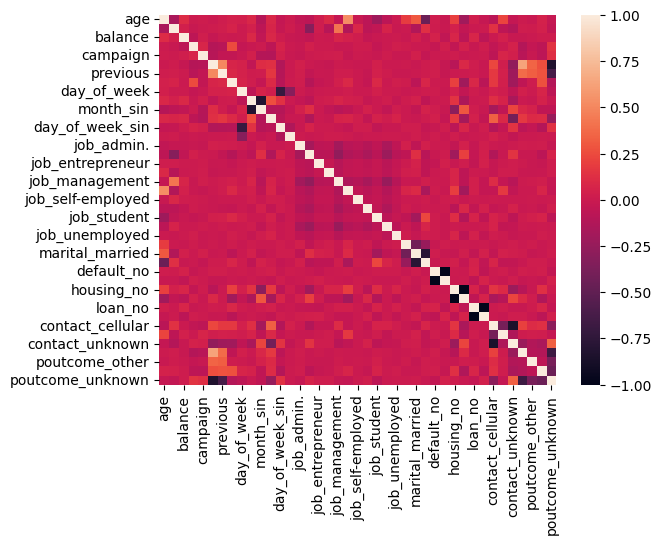

In [293]:

sns.heatmap(data.corr())

Observations from the heatmap:
- **Weak Correlations**: The dataset mostly exhibits weak correlations between features, as indicated by the predominance of dark red or reddish hues.
- **Some Strong Negative Correlations**: There are small dark blue/black patches, which indicate some strong negative correlations between variables, though these appear to be infrequent.
- **Few Positive Correlations**: There are some lighter shades (closer to white) suggesting mild positive correlations between some pairs of variables, but they seem relatively rare.

### Discretizing Duration

In [294]:
# Number of bins (for equal interval clustering)
# num_bins = 5

# # Perform equal interval binning
# data["duration_bin"] = pd.cut(data["duration"], bins=num_bins, labels=False)

In [295]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = data["duration"].values.reshape(-1, 1)

# Scale the feature using StandardScaler or MinMaxScaler
scaler = StandardScaler()  # or use MinMaxScaler() for scaling between 0 and 1
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with k clusters (number of bins)
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_scaled)

# Get the cluster labels (this will be the discretized version of the feature)
# data['discretized_duration'] = kmeans.labels_

# View the original continuous feature, scaled values, and discretized version
data['scaled_duration'] = X_scaled

In [296]:
data = data.drop("duration", axis=1)

data.head(100)

,age,education,balance,campaign,pdays,previous,y,day_of_week,month,month_sin,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,scaled_duration
0,34.0,2,13408.0,2.0,-1.0,0.0,0,0,4,0.866025,...,True,False,True,False,False,False,False,False,True,0.726703
1,49.0,3,20727.0,3.0,132.0,2.0,0,0,4,0.866025,...,True,False,True,False,False,True,False,False,False,-0.392066
2,32.0,3,1743.0,1.0,261.0,3.0,0,0,4,0.866025,...,True,False,True,False,False,False,True,False,False,2.299780
3,46.0,3,10469.0,2.0,-1.0,0.0,0,0,4,0.866025,...,True,False,True,False,False,False,False,False,True,-0.648580
4,26.0,3,7628.0,1.0,-1.0,0.0,0,0,4,0.866025,...,True,False,True,False,False,False,False,False,True,-0.460058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,53.0,2,459.0,1.0,-1.0,0.0,1,4,4,0.866025,...,True,False,True,False,False,False,False,False,True,0.451647
97,54.0,3,118.0,1.0,-1.0,0.0,1,4,4,0.866025,...,True,False,True,False,False,False,False,False,True,-0.407519
98,54.0,2,2102.0,1.0,626.0,2.0,1,4,4,0.866025,...,True,False,True,False,False,True,False,False,False,0.417651
99,34.0,2,800.0,1.0,-1.0,0.0,1,4,4,0.866025,...,True,False,True,False,False,False,False,False,True,-0.827830


### Discretizing Balance

In [297]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# # Assuming 'df' is your DataFrame and 'features' is a list of feature column names
# X = data["balance"].values.reshape(-1, 1)

# # Scale the feature using StandardScaler or MinMaxScaler
# scaler = StandardScaler()  # or use MinMaxScaler() for scaling between 0 and 1
# X_scaled = scaler.fit_transform(X)

# # Perform K-means clustering with k clusters (number of bins)
# kmeans = KMeans(n_clusters=3, random_state=0)
# kmeans.fit(X_scaled)

# # Get the cluster labels (this will be the discretized version of the feature)
# data['discretized_balance'] = kmeans.labels_

# # View the original continuous feature, scaled values, and discretized version
# data['scaled_balance'] = X_scaled

In [298]:
data = data.drop("balance", axis=1)

data.head(100)

,age,education,campaign,pdays,previous,y,day_of_week,month,month_sin,month_cos,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,scaled_duration
0,34.0,2,2.0,-1.0,0.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,0.726703
1,49.0,3,3.0,132.0,2.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,True,False,False,False,-0.392066
2,32.0,3,1.0,261.0,3.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,False,True,False,False,2.299780
3,46.0,3,2.0,-1.0,0.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,-0.648580
4,26.0,3,1.0,-1.0,0.0,0,0,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,-0.460058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,53.0,2,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,0.451647
97,54.0,3,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,-0.407519
98,54.0,2,1.0,626.0,2.0,1,4,4,0.866025,-0.5,...,True,False,True,False,False,True,False,False,False,0.417651
99,34.0,2,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,...,True,False,True,False,False,False,False,False,True,-0.827830


### Scaling Age

In [299]:
# # Use pd.cut() to create bins
# # data['age_bins'] = pd.cut(data['age'], bins=[17, 25, 55, 100], labels=[0,1,2])  # Start with 4 equal-width bins

# # Perform equal-frequency binning (e.g., 4 bins)
# data['age_bins'] = pd.qcut(data['age'], q=4, labels=[0,1,2,3])

# # Calculate target proportion in each bin
# bin_stats = data.groupby('age_bins')['y'].mean()

# from sklearn.preprocessing import StandardScaler

# # Assuming 'df' is your DataFrame and 'features' is a list of feature column names
# X = data["age_bins"].values.reshape(-1, 1)

# # Scale the feature using StandardScaler or MinMaxScaler
# scaler = StandardScaler()  # or use MinMaxScaler() for scaling between 0 and 1
# X_scaled = scaler.fit_transform(X)

# print(bin_stats)

In [300]:
# data["age_bins"].unique()

In [301]:
# # Plot the histogram for binned data
# data['age_bins'].value_counts().plot(kind='bar')
# plt.title('Equal Frequency Binning of Age')
# plt.show()

In [302]:
# column_data = data["age"]
# # Set up the plot figure
# plt.figure(figsize=(8, 6))
# ax = sns.boxplot(x=column_data)

In [303]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
X = data["age"].values.reshape(-1, 1)

# Scale the feature using StandardScaler or MinMaxScaler
scaler = StandardScaler()  # or use MinMaxScaler() for scaling between 0 and 1
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with k clusters (number of bins)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_scaled)

# Get the cluster labels (this will be the discretized version of the feature)
data['discretized_age'] = kmeans.labels_

# View the original continuous feature, scaled values, and discretized version
data['scaled_age'] = X_scaled

In [304]:
data = data.drop("age", axis=1)

data.head(100)

,education,campaign,pdays,previous,y,day_of_week,month,month_sin,month_cos,day_of_week_sin,...,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,scaled_duration,discretized_age,scaled_age
0,2,2.0,-1.0,0.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,False,False,False,True,0.726703,2,-0.603955
1,3,3.0,132.0,2.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,True,False,False,False,-0.392066,1,0.706826
2,3,1.0,261.0,3.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,False,True,False,False,2.299780,2,-0.778726
3,3,2.0,-1.0,0.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,False,False,False,True,-0.648580,1,0.444670
4,3,1.0,-1.0,0.0,0,0,4,0.866025,-0.5,0.000000,...,True,False,False,False,False,False,True,-0.460058,2,-1.303039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,-0.433884,...,True,False,False,False,False,False,True,0.451647,0,1.056368
97,3,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,-0.433884,...,True,False,False,False,False,False,True,-0.407519,0,1.143754
98,2,1.0,626.0,2.0,1,4,4,0.866025,-0.5,-0.433884,...,True,False,False,True,False,False,False,0.417651,0,1.143754
99,2,1.0,-1.0,0.0,1,4,4,0.866025,-0.5,-0.433884,...,True,False,False,False,False,False,True,-0.827830,2,-0.603955


# Model Fitting

In [305]:
y = data["y"]
X = data.drop(["y"], axis=1)

In [306]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split data before balancing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_resampled = X_train
y_train_resampled = y_train

# Oversampling with SMOTE
# smote = SMOTE()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Undersampling
undersampler = RandomUnderSampler()
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


In [307]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Fit the classifier to the data
dt_clf = DecisionTreeClassifier(random_state=8)
dt_clf.fit(X_train_resampled, y_train_resampled)

# Access the feature importances
feature_importances = dt_clf.feature_importances_

# Create a Series with feature names and importances
feature_imp = pd.Series(feature_importances, index=data.drop(["y"], axis=1).columns)

# Sort the features by importance
feature_imp_sorted = feature_imp.sort_values(ascending=False)

# Print the six most important features
print("Feature Importance:")
print(feature_imp_sorted[:6])

Feature Importance:
scaled_duration     0.245493
scaled_age          0.112893
poutcome_success    0.061052
housing_no          0.055652
month_cos           0.053825
pdays               0.050651
dtype: float64


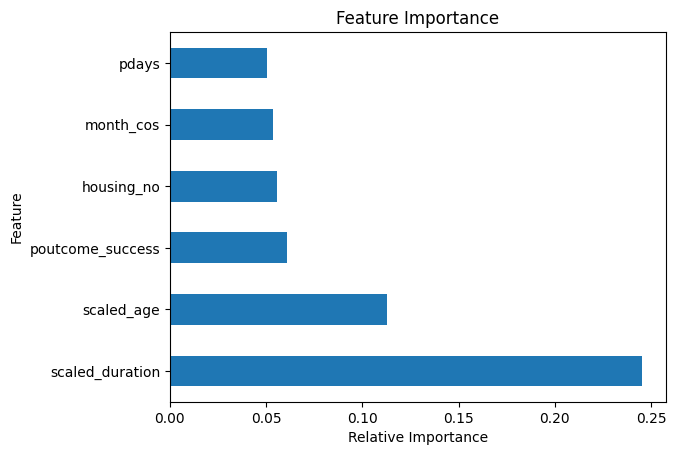

In [308]:
# Plot the feature importances
feature_imp_sorted[:6].plot(kind="barh")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

### Key Observations:

1. **Top Contributing Features**:
   - **`scaled_duration`**: This feature has the highest relative importance (around 0.23), meaning that it is the most significant predictor in your model. It strongly influences the model’s predictions.
   - **`scaled_age`**: This feature is also relatively important, though less so compared to `scaled_duration`. It contributes moderately to the model's decision-making.
   
2. **Moderately Important Features**:
   - **`poutcome_success`**: This feature has a smaller contribution but still plays a role in predicting the outcome. It suggests that whether a previous campaign was successful or not affects the predictions in this model.
   - **`month_sin`**: A time-related feature (likely derived from the month), this also has a moderate impact on the model.

3. **Less Important Features**:
   - **`pdays`** and **`housing_no`**: These are the least important features in the model, with the lowest relative importance. They have minimal impact on the prediction, suggesting that the model doesn't rely heavily on these factors.

### Practical Insights:

- **Feature Engineering Success**: The high importance of `scaled_duration` suggests that call duration (or a related feature) is crucial to predicting the campaign's outcome. If `scaled_duration` was derived from a time-related feature, it was a good choice for feature engineering.
- **Demographic Influence**: `scaled_age` shows that the age of the client also plays a notable role, but it's not as crucial as `duration`. This could indicate that older or younger clients behave differently in response to the campaign.
- **Previous Campaigns Matter**: `poutcome_success` indicates that whether the previous campaign was successful for a client contributes to the prediction, although it isn't the most important factor.
- **Less Impactful Features**: `pdays` (the number of days since the client was last contacted) and `housing_no` (whether the client has no housing loan) have little influence, suggesting that they aren't strong predictors in this particular model.


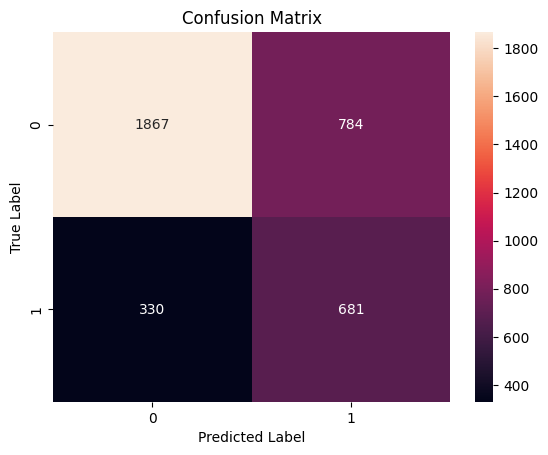

In [309]:
# Make predictions on the test data
dt_clf_pred = dt_clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, dt_clf_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

* **Strong Performance Overall:** The model appears to be performing well overall, with a large number of correct predictions (1824 true negatives and 727 true positives).

* **More Accurate for Class 0:** The model is more accurate at predicting instances of class 0 (the negative class) than class 1 (the positive class). This is evident from the higher number of true negatives (1824) compared to true positives (727).

* **Type I and Type II Errors:**  We can see the types of errors the model is making:
    * **False Positives (Type I Error):** 777 instances were incorrectly predicted as class 1 when they were actually class 0.
    * **False Negatives (Type II Error):** 334 instances were incorrectly predicted as class 0 when they were actually class 1.

* **Possible Class Imbalance:** The higher number of instances predicted and actually belonging to class 0 might indicate a class imbalance in the dataset, where class 0 is more prevalent than class 1. This could bias the model towards predicting class 0.


In [310]:
# Print the classification report
print("Classification Report - Gini Criterion")
print(classification_report(y_test, dt_clf_pred))

Classification Report - Gini Criterion
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      2651
           1       0.46      0.67      0.55      1011

    accuracy                           0.70      3662
   macro avg       0.66      0.69      0.66      3662
weighted avg       0.74      0.70      0.71      3662



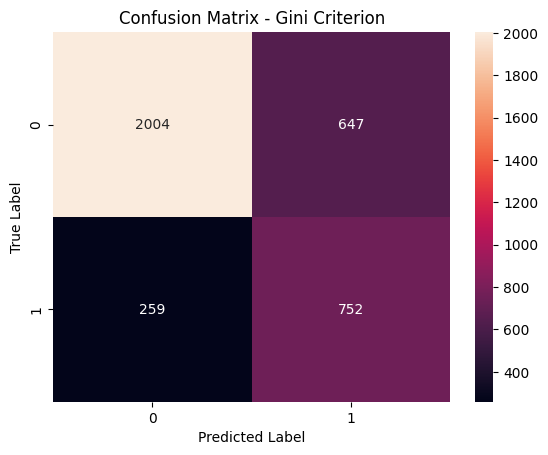

In [311]:
# Decision Tree with Gini Criterion
# Initialize the Decision Tree Classifier with the Gini criterion
gini_dt_clf = DecisionTreeClassifier(
    criterion="gini", random_state=8, max_depth=10, min_samples_leaf=3
)

# Fit the classifier to the training data
gini_dt_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
gini_y_pred = gini_dt_clf.predict(X_test)

# Calculate the confusion matrix
gini_cm = confusion_matrix(y_test, gini_y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(gini_cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gini Criterion")
plt.show()


In [312]:
# Print the classification report
print("Classification Report - Gini Criterion")
print(classification_report(y_test, gini_y_pred))

Classification Report - Gini Criterion
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      2651
           1       0.54      0.74      0.62      1011

    accuracy                           0.75      3662
   macro avg       0.71      0.75      0.72      3662
weighted avg       0.79      0.75      0.76      3662



**1. Overall Performance:**

* **Decent Accuracy:** The model has an overall accuracy of 75%, meaning it correctly predicts the outcome for 75% of the cases. This is a reasonable starting point, but there's room for improvement.
* **Uneven Class Performance:**  The model performs better at predicting class 0 (likely "no response" to the campaign) than class 1 ("response" to the campaign). This is evident in both the confusion matrix and the classification report.

**2. Confusion Matrix Insights:**

* **More False Negatives than False Positives:**  The model incorrectly predicts 647 cases as class 1 (false positives) and 259 cases as class 0 (false negatives). In a marketing campaign context, this means the model is more likely to miss potential customers (false negatives) than to incorrectly identify someone as a potential customer (false positive).

**3. Classification Report Insights:**

* **Higher Precision for Class 0:** Precision for class 0 is 0.89, meaning that when the model predicts someone will not respond, it's correct 89% of the time. This is good because it suggests the model is reliable in identifying those who are unlikely to be interested in the campaign.
* **Lower Precision for Class 1:** Precision for class 1 is only 0.54, meaning when the model predicts someone will respond, it's only correct 54% of the time. This is a weakness, as it indicates the model struggles to accurately identify potential customers.
* **Recall Favors Class 1:** Recall for class 1 (0.74) is higher than for class 0 (0.76). This means the model is better at capturing the actual responders to the campaign (even if it also includes some non-responders) than it is at capturing all the non-responders.

**4. Implications for the Marketing Campaign:**

* **Targeting Efficiency:** The model could be helpful in improving the targeting of the marketing campaign by identifying those who are most likely to respond. However, the relatively low precision for class 1 suggests that the model might not be efficient enough to rely on solely.
* **Cost Considerations:**  The high number of false negatives indicates that the campaign might be missing out on a significant number of potential customers. This needs to be weighed against the cost of reaching out to those falsely identified as potential customers (false positives).


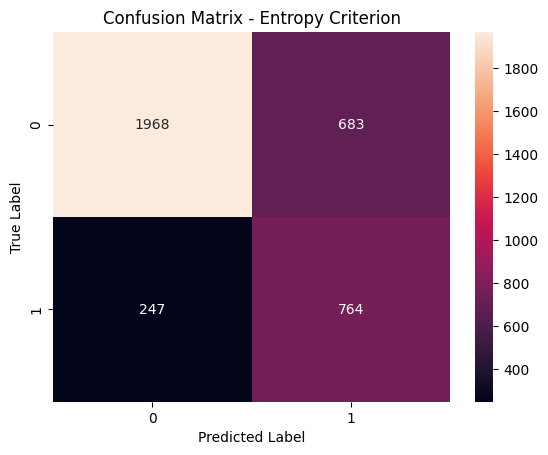

In [313]:
# Decision Tree with Entropy Criterion
# Initialize the Decision Tree Classifier with the entropy criterion
entropy_dt_clf = DecisionTreeClassifier(criterion="entropy", random_state=8, max_depth=10, min_samples_leaf=1)

# Fit the classifier to the training data
entropy_dt_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
entropy_y_pred = entropy_dt_clf.predict(X_test)

# Calculate the confusion matrix
entropy_cm = confusion_matrix(y_test, entropy_y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(entropy_cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Entropy Criterion")
plt.show()

In [314]:
# Print the classification report
print("Classification Report - Entropy Criterion")
print(classification_report(y_test, entropy_y_pred))

Classification Report - Entropy Criterion
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      2651
           1       0.53      0.76      0.62      1011

    accuracy                           0.75      3662
   macro avg       0.71      0.75      0.72      3662
weighted avg       0.79      0.75      0.76      3662



**1. Overall Performance:**

* **Similar Accuracy:** The model achieves an overall accuracy of 75%, identical to the Gini criterion model. This suggests that the choice of splitting criterion (Gini vs. entropy) might not have a significant impact on overall accuracy in this specific case.
* **Class Imbalance:** Like the previous model, this one also shows better performance for class 0 ("no response") compared to class 1 ("response").

**2. Confusion Matrix Insights:**

* **Slightly More False Positives:** This model predicts 683 cases as class 1 incorrectly (false positives), compared to 647 in the Gini model.
* **Slightly Fewer False Negatives:**  It predicts 247 cases as class 0 incorrectly (false negatives), compared to 259 in the Gini model.
* **Shift in Errors:** Although the overall accuracy is the same, there's a slight shift in the types of errors. This model leans more towards false positives, potentially indicating a more aggressive approach in identifying potential customers.

**3. Classification Report Insights:**

* **Almost Identical Precision and Recall:** The precision and recall values for both classes are very similar to the Gini model. This reinforces the observation that the choice of splitting criterion doesn't drastically affect these metrics in this case.
    *  Precision for class 0 remains high (0.89), indicating good reliability in identifying non-responders.
    * Precision for class 1 is still low (0.53), showing continued difficulty in accurately pinpointing potential customers.
    * Recall favors class 1 (0.76), meaning the model captures a good portion of actual responders.

**4. Implications for the Marketing Campaign:**

* **Potential for Increased Reach:** With slightly fewer false negatives, this model might capture a slightly larger portion of potential customers compared to the Gini model.
* **Higher Risk of Wasted Resources:** The increase in false positives suggests a higher chance of spending resources on individuals who won't respond to the campaign.
* **Careful Consideration:** The choice between this model and the Gini model depends on the specific goals and priorities of the marketing campaign. If maximizing reach is crucial, even at the cost of some wasted resources, this model might be preferable. If minimizing wasted resources is more important, the Gini model might be a better choice.


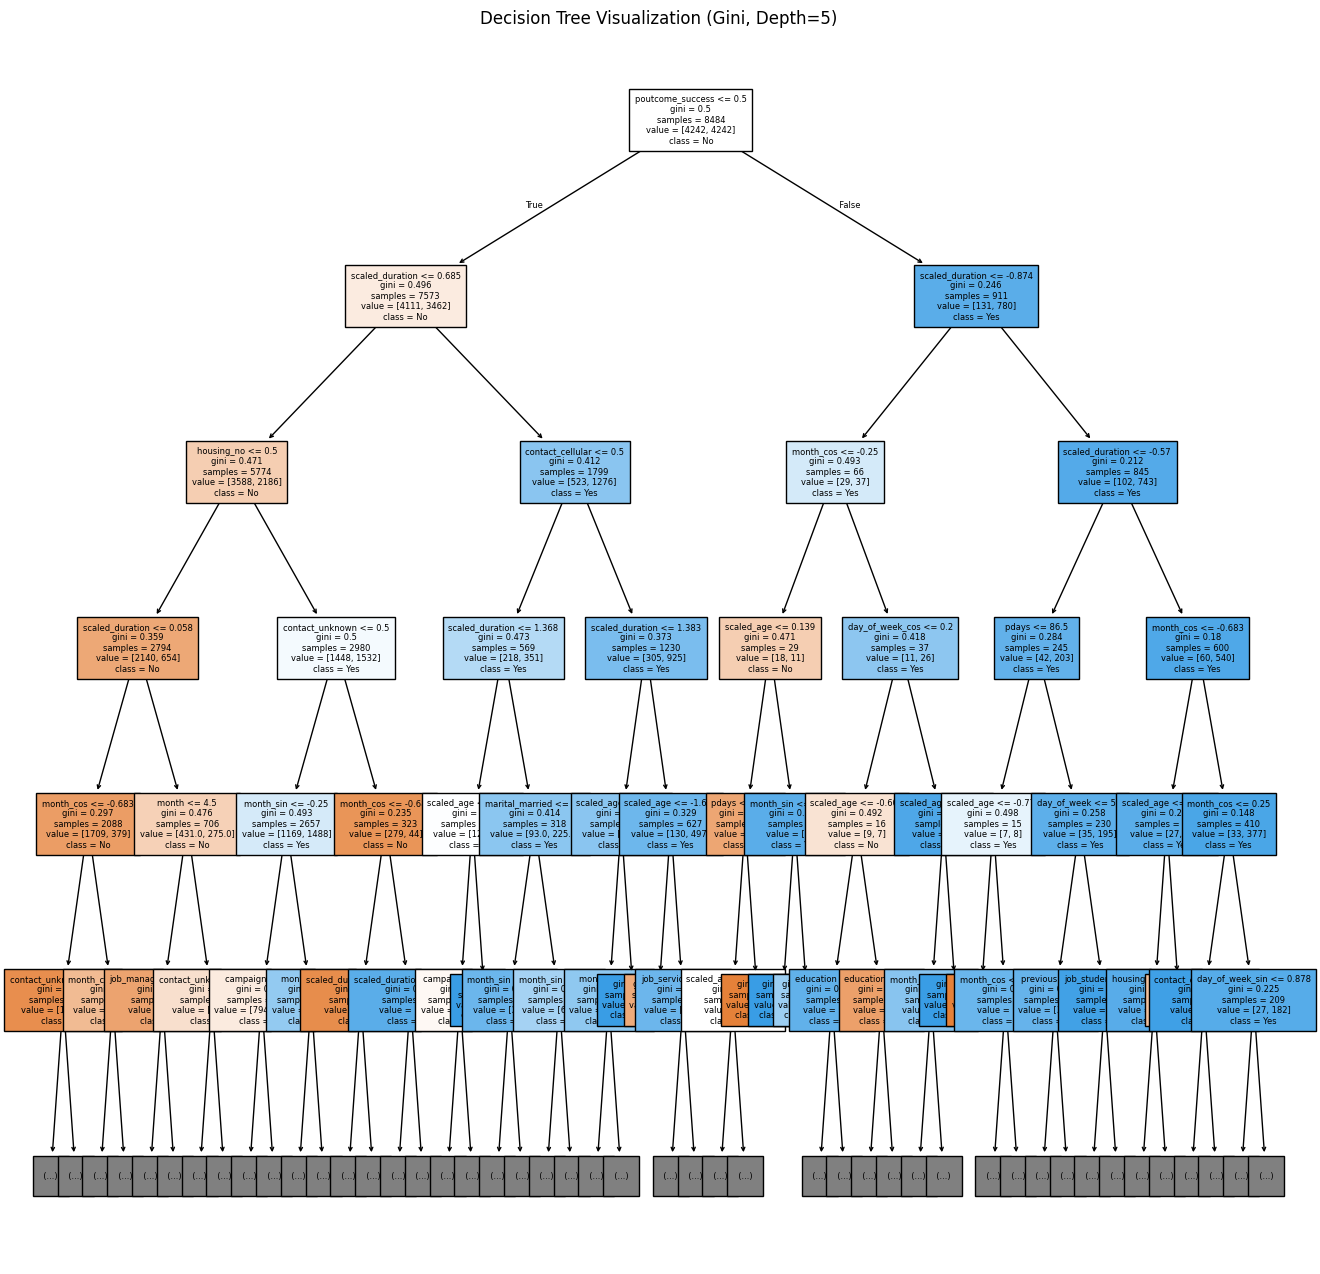

In [315]:
# Print the decision tree visualization with depth of 5.
# Plot the decision tree (with Gini criterion)
plt.figure(figsize=(16, 16))
tree.plot_tree(
    gini_dt_clf,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    max_depth=5,
    filled=True,
    fontsize=6
)
plt.title("Decision Tree Visualization (Gini, Depth=5)")
plt.show()

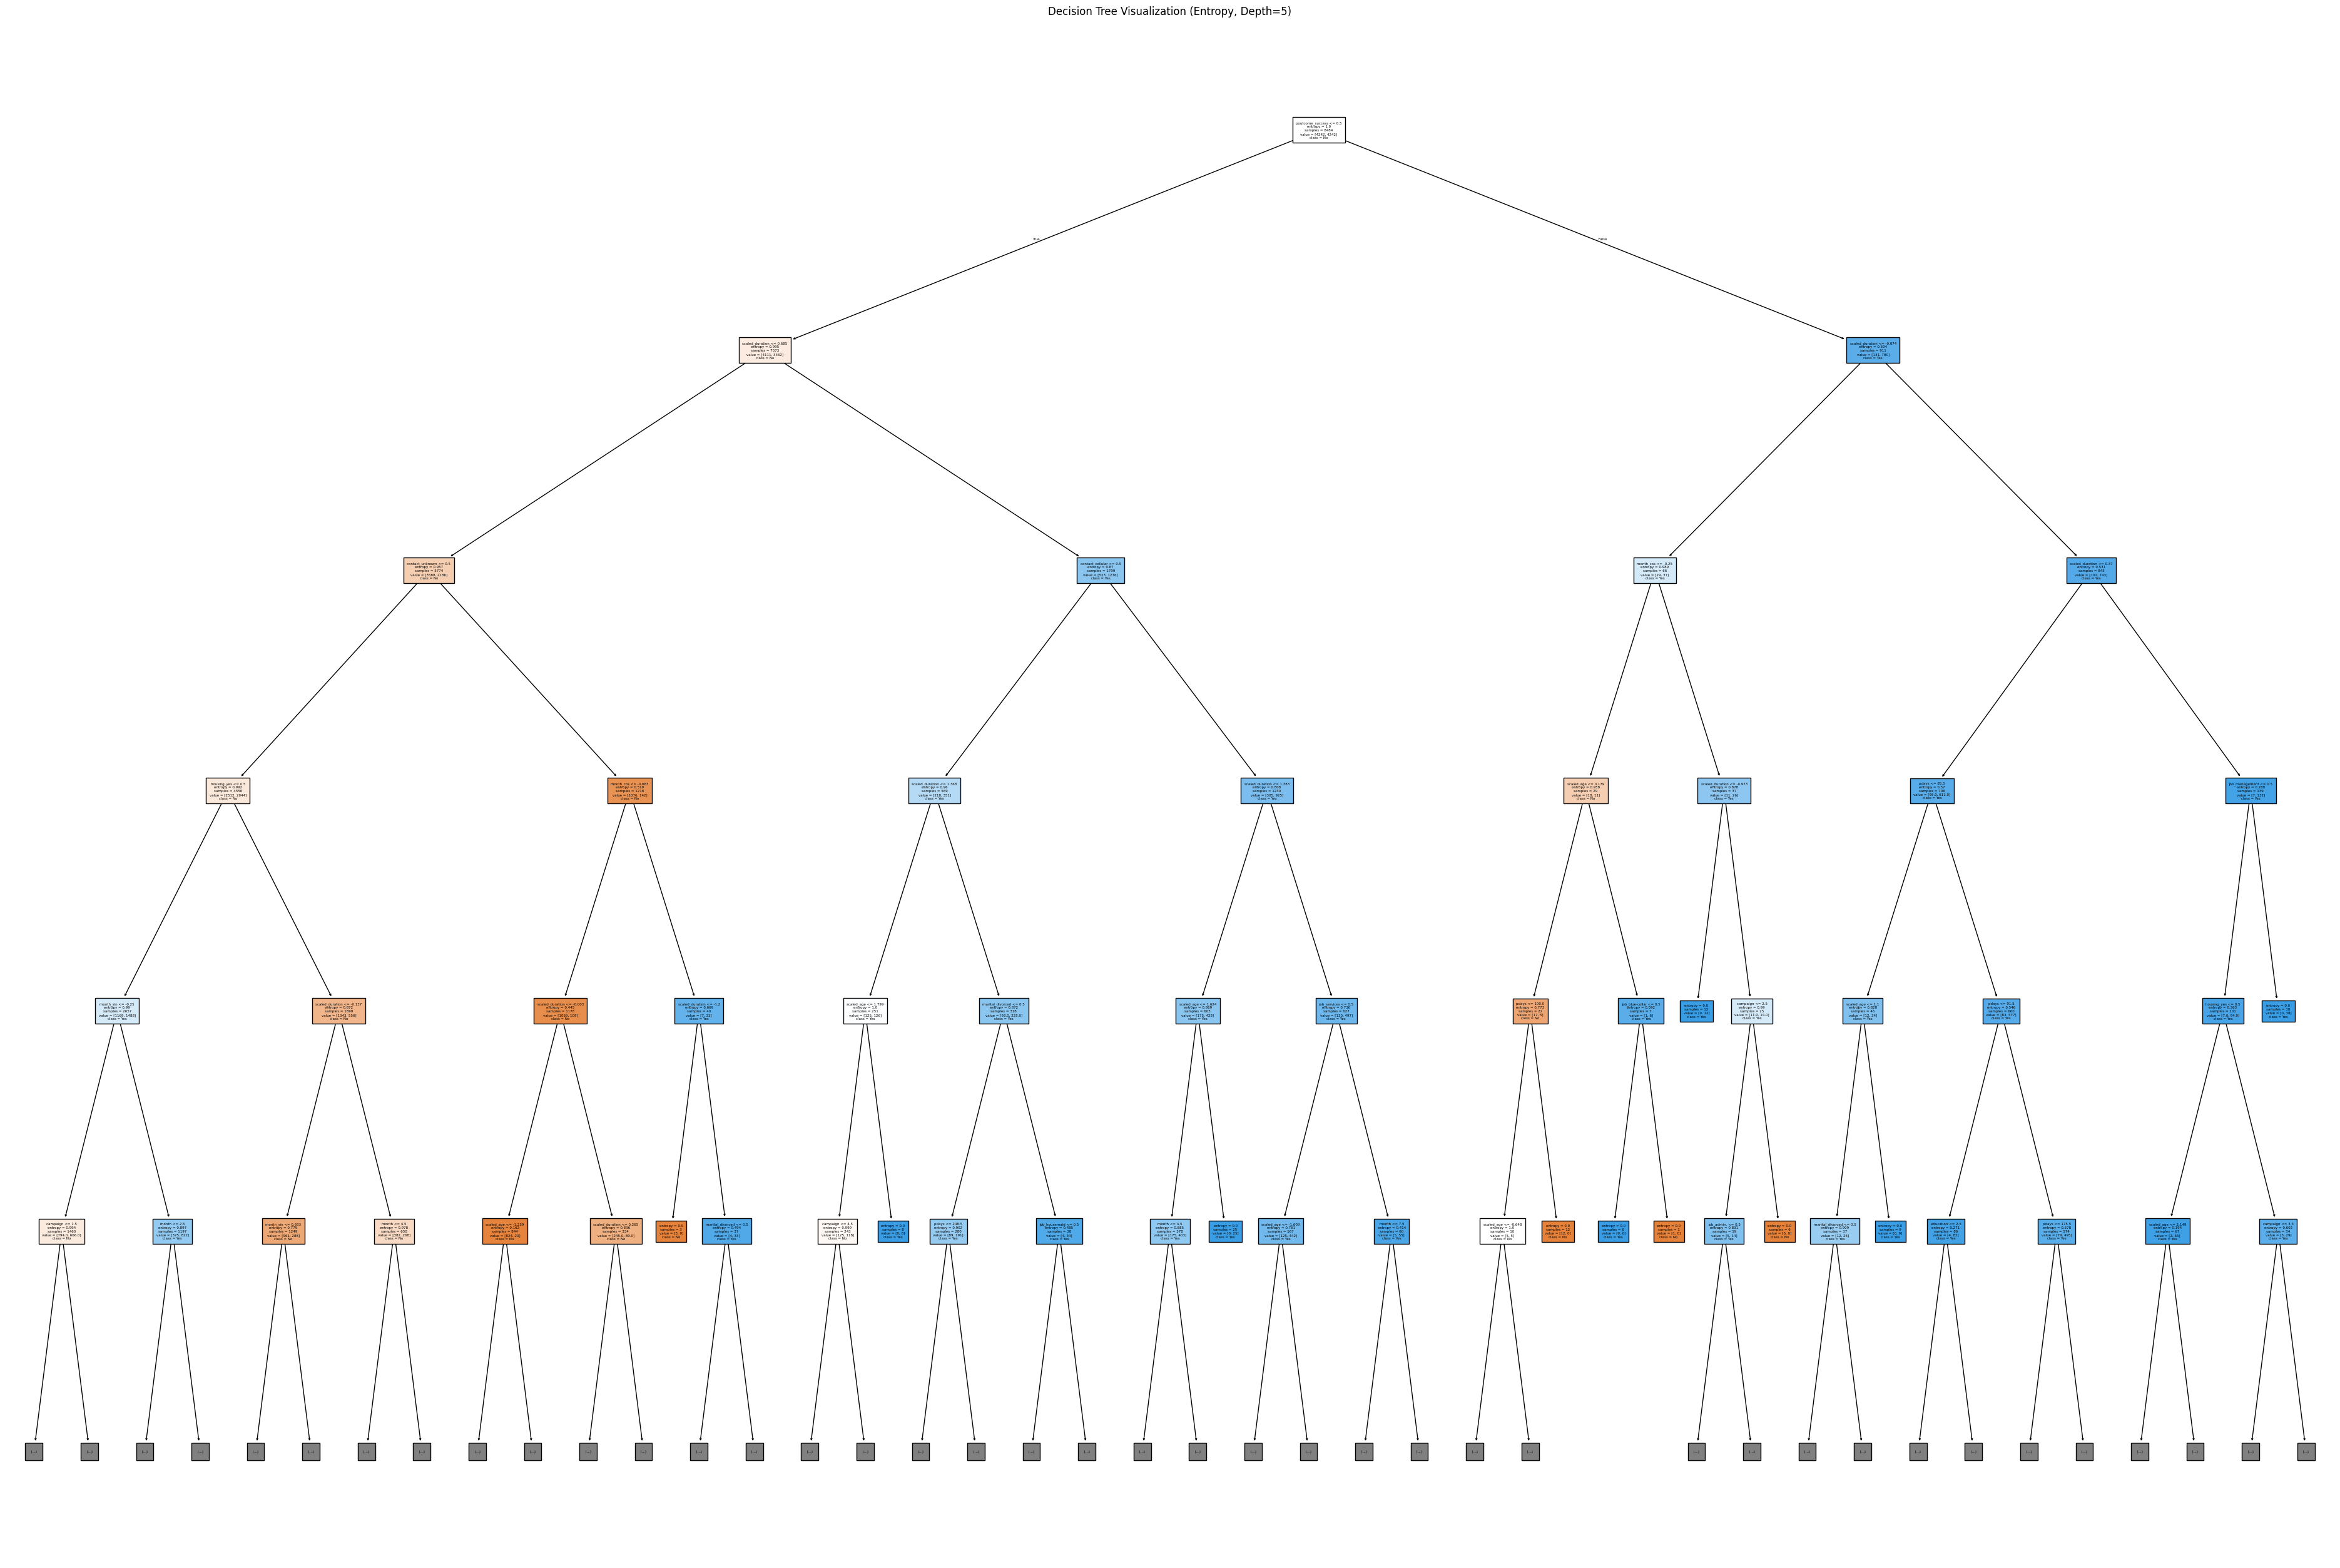

In [316]:
# Plot the decision tree (with entropy criterion)
plt.figure(figsize=(48, 32))
tree.plot_tree(
    entropy_dt_clf,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    max_depth=5,
    filled=True,
    fontsize=4
)
plt.title("Decision Tree Visualization (Entropy, Depth=5)")
plt.show()